In [1]:
!pip install yahoofinancials
!pip install yfinance
!pwd

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15194 sha256=cfd76c38d984705ee23ff8636441901bd50cb750ed11650d558c8c0033c41c79
  Stored in directory: c:\users\szymon\appdata\local\pip\cache\wheels\6a\90\0c\08c7ac2ce60b9ac91529417d471e59244f9f96848c86f14809
Successfully built yahoofinancials
  Using cached multitasking-0.0.9.tar.gz (8.1 kB)
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22622 sha256=daf89bb4812716b1b3ffc57ff4c5e872d5e5de878d92b70b33c22bb7d933da11
  Stored in directory: c:\users\szymon\appdata\local\pip\cache\wheels\b4\c3\39\9c01ae2b4726f37024bba5592bec868b47a2fab5a786e8979a
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8374 sha256=9a8b009de4d02caaaec841a177293abe7a87dd49b8949a19acb682b20a437a61
  Stored in directory: c:\users\szymon\appdata\local\pip\cache\wheels\57\6d\a3\a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitaskin

In [2]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt

In [3]:
yahoo_financials = YahooFinancials('TSLA')

data = yahoo_financials.get_historical_price_data(start_date='2014-01-01', 
                                                  end_date='2019-12-31', 
                                                  time_interval='daily')

tsla_df = pd.DataFrame(data['TSLA']['prices'])
tsla_df['date'] = pd.to_datetime(tsla_df['formatted_date'])
tsla_df.drop('formatted_date', inplace=True, axis=1)
tsla_df.set_index('date', inplace=True)
# tsla_df = tsla_df.drop('date', axis=1).set_index('formatted_date')
tsla_df.head()

,high,low,open,close,volume,adjclose
date,,,,,,
2014-01-02,30.496,29.309999,29.959999,30.020000,30942000,30.020000
2014-01-03,30.438,29.719999,30.000000,29.912001,23475000,29.912001
2014-01-06,30.080,29.048000,30.000000,29.400000,26805500,29.400000
2014-01-07,30.080,29.049999,29.524000,29.872000,25170500,29.872000
2014-01-08,30.740,29.752001,29.770000,30.256001,30816000,30.256001


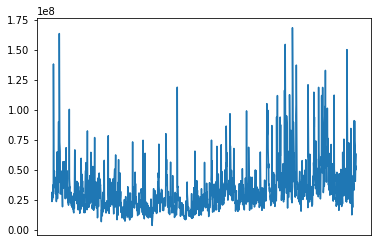

In [4]:
plt.figure()
plt.xticks(range(0, len(tsla_df.volume), 30*4), range(0,12))
plt.plot(tsla_df.volume)
plt.show()

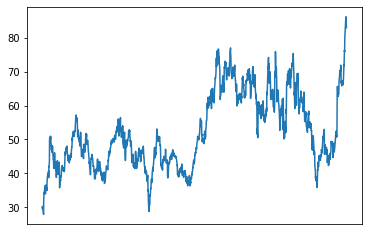

In [5]:
plt.figure()
plt.xticks(range(0, len(tsla_df.close), 30*4), range(0,12))
plt.plot(tsla_df.close)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Epoch 1/15
900/900 [==============================] - 6s 6ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2/15
900/900 [==============================] - 5s 6ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/15
900/900 [==============================] - 5s 6ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/15
900/900 [==============================] - 5s 6ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 5/15
900/900 [==============================] - 5s 6ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 6/15
297/297 [==============================] - 0s 2ms/step - loss: 0.0064 - mse: 0.0064


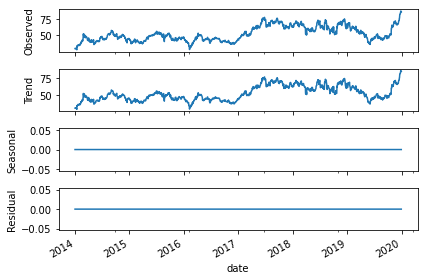

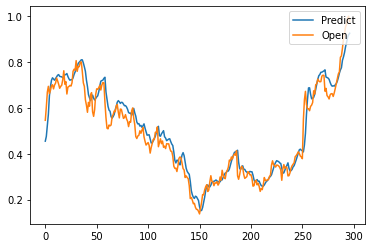

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tsla_df['open'], freq=1)
result.plot()

tsla_df.isna().any()

X = tsla_df.loc[:, 'high':'volume']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

n_feature = 5
n_steps = 5
train_size = 0.8
test_size = 0.2
valid_size = 0.25

from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(X, train_size=train_size, test_size=test_size, shuffle=False)
Xtrain, Xvalidate = train_test_split(Xtrain, train_size = 0.75, test_size= valid_size, shuffle=False)

# tworzymy szereg czasowy
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_gen = TimeseriesGenerator(Xtrain, Xtrain, length=n_steps, batch_size=1, sampling_rate=1)
valid_gen = TimeseriesGenerator(Xvalidate, Xvalidate, length=n_steps, batch_size=1, sampling_rate=1)
test_gen = TimeseriesGenerator(Xtest, Xtest, length=n_steps, batch_size=1, sampling_rate=1)


from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

def LSTM_model(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(30, activation='relu',
                   return_sequences=True,
                   input_shape=(n_steps, n_features)))
    model.add(LSTM(30, activation='sigmoid'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse',
                  metrics=['mse'])
    return model

model = LSTM_model(n_steps, n_feature)
history = model.fit(train_gen, epochs=15, validation_data=valid_gen, 
                    callbacks=[EarlyStopping(monitor='val_loss')])

scores = model.evaluate(test_gen)
scores

train_predict = model.predict(train_gen)
train_predict

test_predict = model.predict(test_gen)
x = test_predict[0:, 0]
y = Xtest[n_steps:,0]
plt.figure()
plt.plot(x)
plt.plot(y)
plt.legend(['Predict', 'Open'], loc='upper right')
plt.show()